In [ ]:
# check if TensorFlow can access the GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from tqdm import tqdm
import random

In [ ]:
# codigo del filtro anisotrópico
def anisodiff(img, niter=1, kappa=50, gamma=0.1, step=(1.,1.), option=1, ploton=False):
    """
    Anisotropic diffusion.
    """
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)

    img = img.astype('float32')
    imgout = img.copy()

    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    for ii in range(niter):
        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)

        if option == 1:
            gS = np.exp(-(deltaS/kappa)**2.)/step[0]
            gE = np.exp(-(deltaE/kappa)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaS/kappa)**2.)/step[0]
            gE = 1./(1.+(deltaE/kappa)**2.)/step[1]

        E = gE*deltaE
        S = gS*deltaS

        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]

        imgout += gamma*(NS+EW)

    return imgout

class AnisotropicFilterDataset:
    """Clase para manejar el dataset y generar ventanas de entrenamiento"""

    def __init__(self, image_dir, window_size=32, num_samples=50000):
        self.image_dir = image_dir
        self.window_size = window_size
        self.num_samples = num_samples
        self.images = []
        self.filtered_images = []

    def load_and_process_images(self):
        """Cargar imágenes, convertir a escala de grises y aplicar filtro anisotrópico"""
        print("Cargando y procesando imágenes...")

        image_files = [f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png', '.bmp'))]

        for filename in tqdm(image_files, desc="Procesando imágenes"):
            # Cargar imagen
            img_path = os.path.join(self.image_dir, filename)
            img = cv2.imread(img_path)

            if img is not None:
                # Convertir a escala de grises
                if len(img.shape) == 3:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    gray_img = img

                # Normalizar a [0, 1]
                gray_img = gray_img.astype(np.float32) / 255.0

                # Aplicar filtro anisotrópico
                filtered_img = anisodiff(gray_img,
                                       niter=50,
                                       kappa=20,
                                       gamma=0.2,
                                       step=(1.,1.),
                                       option=1,
                                       ploton=False)

                self.images.append(gray_img)
                self.filtered_images.append(filtered_img)

        print(f"Procesadas {len(self.images)} imágenes")

    def generate_windows(self):
        """Generar ventanas aleatorias de las imágenes para entrenamiento"""
        print(f"Generando {self.num_samples} ventanas de {self.window_size}x{self.window_size}...")

        X_windows = []
        y_windows = []

        for _ in tqdm(range(self.num_samples), desc="Generando ventanas"):
            # Seleccionar imagen aleatoria
            img_idx = random.randint(0, len(self.images) - 1)
            original_img = self.images[img_idx]
            filtered_img = self.filtered_images[img_idx]

            # Obtener dimensiones
            h, w = original_img.shape

            # Verificar que la imagen sea lo suficientemente grande
            if h >= self.window_size and w >= self.window_size:
                # Seleccionar posición aleatoria
                y_start = random.randint(0, h - self.window_size)
                x_start = random.randint(0, w - self.window_size)

                # Extraer ventanas
                x_window = original_img[y_start:y_start+self.window_size,
                                      x_start:x_start+self.window_size]
                y_window = filtered_img[y_start:y_start+self.window_size,
                                      x_start:x_start+self.window_size]

                X_windows.append(x_window)
                y_windows.append(y_window)

        # Convertir a arrays numpy y añadir dimensión de canal
        X_windows = np.array(X_windows)[..., np.newaxis]
        y_windows = np.array(y_windows)[..., np.newaxis]

        print(f"Generadas {len(X_windows)} ventanas")
        return X_windows, y_windows

    def split_data(self, X, y, test_size=0.2, val_size=0.1):
        """Dividir datos en entrenamiento, validación y prueba"""
        # Dividir en entrenamiento + validación y prueba
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # Dividir temp en entrenamiento y validación
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size/(1-test_size), random_state=42
        )

        print(f"Datos divididos:")
        print(f"  Entrenamiento: {len(X_train)} muestras")
        print(f"  Validación: {len(X_val)} muestras")
        print(f"  Prueba: {len(X_test)} muestras")

        return X_train, X_val, X_test, y_train, y_val, y_test

def create_unet_model(input_size=(32, 32, 1), depth=4):
    """Crear modelo U-Net"""
    inputs = keras.Input(shape=input_size)

    # Encoder (contracción)
    skips = []
    x = inputs

    filters = 64
    for i in range(depth):
        # Convoluciones
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)

        # Guardar para skip connection
        if i < depth - 1:  # No guardar la última capa
            skips.append(x)
            x = layers.MaxPooling2D(2)(x)
            filters *= 2

    # Decoder (expansión)
    for i in range(depth - 1):
        filters //= 2

        # Upsampling
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)

        # Skip connection
        skip = skips.pop()
        x = layers.Concatenate()([x, skip])

        # Convoluciones
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)

    # Capa de salida
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name='U-Net')
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """Entrenar el modelo U-Net"""
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]

    # Entrenar
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return history

def sliding_window_inference(model, image, window_size=32, stride=16):
    """Realizar inferencia usando ventanas deslizantes"""
    h, w = image.shape

    # Crear imagen de salida y matriz de conteo para promedio
    output_image = np.zeros_like(image)
    count_matrix = np.zeros_like(image)

    # Calcular número de ventanas
    num_windows_h = (h - window_size) // stride + 1
    num_windows_w = (w - window_size) // stride + 1

    # Preparar batch de ventanas
    windows = []
    positions = []

    for i in range(0, h - window_size + 1, stride):
        for j in range(0, w - window_size + 1, stride):
            window = image[i:i+window_size, j:j+window_size]
            windows.append(window)
            positions.append((i, j))

    # Convertir a tensor
    windows = np.array(windows)[..., np.newaxis]

    # Realizar predicción
    predictions = model.predict(windows, batch_size=32, verbose=0)

    # Reconstruir imagen
    for k, (i, j) in enumerate(positions):
        pred_window = predictions[k, :, :, 0]
        output_image[i:i+window_size, j:j+window_size] += pred_window
        count_matrix[i:i+window_size, j:j+window_size] += 1

    # Promedio donde hay solapamiento
    output_image = np.divide(output_image, count_matrix,
                           out=np.zeros_like(output_image),
                           where=count_matrix!=0)

    return output_image

def evaluate_model(model, test_image_path, window_size=32):
    """Evaluar modelo con una imagen de prueba"""
    # Cargar imagen de prueba
    test_img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    test_img = test_img.astype(np.float32) / 255.0

    # Aplicar filtro anisotrópico real
    ground_truth = anisodiff(test_img, niter=50, kappa=20, gamma=0.2,
                           step=(1.,1.), option=1, ploton=False)

    # Realizar inferencia con U-Net
    predicted = sliding_window_inference(model, test_img, window_size)

    # Calcular métricas
    mse = np.mean((ground_truth - predicted) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))

    # Visualizar resultados
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(test_img, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap='gray')
    plt.title('Filtro Anisotrópico Real')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted, cmap='gray')
    plt.title(f'U-Net Predicción\nPSNR: {psnr:.2f} dB')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return mse, psnr

# Función principal para ejecutar el pipeline completo
def main():
    """Pipeline principal del laboratorio"""

    # Configuración
    IMAGE_DIR = "../input"
    WINDOW_SIZE = 32
    NUM_SAMPLES = 100000 # modificar si se tarda mucho

    print("=== Laboratorio U-Net para Filtros Anisotrópicos ===\n")

    # 1. Crear dataset y procesar imágenes
    print("Paso 1: Procesando imágenes...")
    dataset = AnisotropicFilterDataset(IMAGE_DIR, WINDOW_SIZE, NUM_SAMPLES)
    dataset.load_and_process_images()

    # 2. Generar ventanas
    print("\nPaso 2: Generando ventanas de entrenamiento...")
    X, y = dataset.generate_windows()

    # 3. Dividir datos
    print("\nPaso 3: Dividiendo datos...")
    X_train, X_val, X_test, y_train, y_val, y_test = dataset.split_data(X, y)

    # 4. Crear y entrenar modelo
    print("\nPaso 4: Creando modelo U-Net...")
    model = create_unet_model(input_size=(WINDOW_SIZE, WINDOW_SIZE, 1))
    model.summary()

    print("\nPaso 5: Entrenando modelo...")
    history = train_model(model, X_train, y_train, X_val, y_val)

    # 5. Evaluar modelo
    print("\nPaso 6: Evaluando modelo...")

    # Evaluar en conjunto de prueba
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Pérdida en conjunto de prueba: {test_loss}")

    # Guardar modelo
    model.save('output/unet_anisotropic_filter.h5')
    print("Modelo guardado como 'unet_anisotropic_filter.h5'")

    print("\n=== Laboratorio completado ===")

if __name__ == "__main__":
    main()

=== Laboratorio U-Net para Filtros Anisotrópicos ===

Paso 1: Procesando imágenes...
Cargando y procesando imágenes...


Procesando imágenes: 100%|██████████| 200/200 [00:15<00:00, 12.66it/s]


Procesadas 200 imágenes

Paso 2: Generando ventanas de entrenamiento...
Generando 100000 ventanas de 32x32...


Generando ventanas: 100%|██████████| 100000/100000 [00:00<00:00, 377456.82it/s]


Generadas 100000 ventanas

Paso 3: Dividiendo datos...
Datos divididos:
  Entrenamiento: 70000 muestras
  Validación: 10000 muestras
  Prueba: 20000 muestras

Paso 4: Creando modelo U-Net...


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 256) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 512) │  1,180,160 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 512) │  2,359,808 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 256) │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 512) │          0 │ conv2d_transpose… │
│ (Concatenate)       │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │  1,179,904 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │    295,040 │ concatenate_1[0]

 Total params: 7,696,193 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)


Paso 5: Entrenando modelo...
Epoch 1/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 102s 41ms/step - loss: 0.0028 - mae: 0.0239 - val_loss: 2.5283e-04 - val_mae: 0.0098 - learning_rate: 0.0010
Epoch 2/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 127s 38ms/step - loss: 2.5417e-04 - mae: 0.0098 - val_loss: 3.1053e-04 - val_mae: 0.0122 - learning_rate: 0.0010
Epoch 3/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 141s 37ms/step - loss: 2.2549e-04 - mae: 0.0090 - val_loss: 2.3940e-04 - val_mae: 0.0097 - learning_rate: 0.0010
Epoch 4/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - loss: 2.1505e-04 - mae: 0.0086 - val_loss: 2.1016e-04 - val_mae: 0.0087 - learning_rate: 0.0010
Epoch 5/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 140s 37ms/step - loss: 2.1096e-04 - mae: 0.0085 - val_loss: 1.9606e-04 - val_mae: 0.0075 - learning_rate: 0.0010
Epoch 6/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - loss: 1.9412e-04 - mae: 0.0079 - val_loss: 1.9599e-04 - val_mae: 0.0075 - learning_rate: 0.0010
Epoch 7/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 140s

Pérdida en conjunto de prueba: [0.00017217808635905385, 0.006386670283973217]
Modelo guardado como 'unet_anisotropic_filter.h5'

=== Laboratorio completado ===


In [9]:
from tensorflow.keras.models import load_model

model = load_model("unet_anisotropic_filter.h5", compile=False)

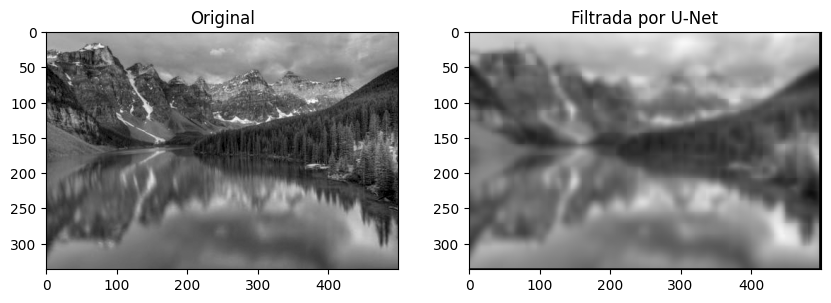

In [ ]:
# Cargar una nueva imagen
img_path = '../TestImages/imagenPrueba1.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

# Hacer inferencia usando ventana deslizante
filtered_img = sliding_window_inference(model, img, window_size=32, stride=16)

# Mostrar resultado
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.title("Filtrada por U-Net")
plt.imshow(filtered_img, cmap='gray')
plt.show()
